<a href="https://colab.research.google.com/github/cyndroy/DP_Skin_Cancer_Classification_using_PATE/blob/master/DP_PATE_SkinCancerClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install syft

In [ ]:
import numpy as np
from PIL import Image
import random
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
import time, os, random
import tensorflow as tf
import torchvision.models as models
from sklearn.metrics import confusion_matrix


# libary from pysyft needed to perform pate analysis
from syft.frameworks.torch.dp import pate

# we'll train on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



---


The dataset with benign and malignant type images are uploaded to the drive and 
the drive is mounted and attached to the colab notebook.

---



In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/CancerDataset'

/content/drive/My Drive/Colab Notebooks/CancerDataset


In [ ]:
class SkinCancerDataset(Dataset):
    def __init__(self, benign_path, malignant_path, transform=None):

        benign_list = [[os.path.join(benign_path, filename),'0'] for filename in os.listdir(benign_path)] 
        malignant_list = [[os.path.join(malignant_path, filename),'1'] for filename in os.listdir(malignant_path)]
       
        self.img_list = []
        self.img_list = benign_list + malignant_list
        random.shuffle(self.img_list)

        self.transform = transform
      

    def __len__(self):
        return len(self.img_list)   

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = int(self.img_list[idx][1])
        return image, label



---


Divided the data into three parts that is trainset, testset and validset. The trainset will be used to train the teachers, the testset will be used to generate private lables for the student training and also for the training of the normal model without PATE and the validset will be used for testing student model and the normal model.

---



In [ ]:
data_transforms = transforms.Compose([
    # transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trainset = SkinCancerDataset(benign_path = './data/train/benign',
                             malignant_path = './data/train/malignant', transform = data_transforms)

testset = SkinCancerDataset(benign_path = './data/test/benign',
                             malignant_path = './data/test/malignant' , transform = data_transforms)

validset = SkinCancerDataset(benign_path = './data/valid/benign',
                             malignant_path = './data/valid/malignant', transform = data_transforms)

len(trainset),len(testset),len(validset)

(2560, 584, 146)

 Image Size torch.Size([16, 3, 224, 224])
 Image Size torch.Size([3, 224, 224])


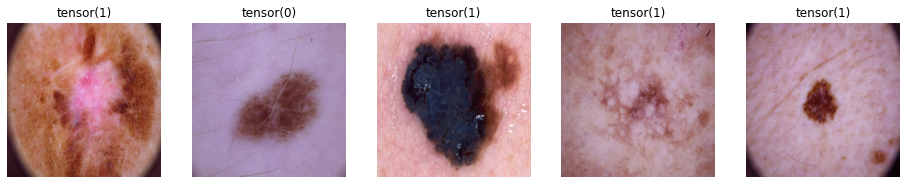

In [ ]:
batchsize=16
data_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

import matplotlib.pyplot as plt

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    #print(type(image))
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

# Displaying Images and other info about the train set
ii=0
images, labels = next(iter(data_loader))
print(" Image Size",images.size())
print(" Image Size",images[ii].size())

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

In [ ]:
# TEACHERS
#divide train set among teachers and create dataloaders for valid and trainsets
num_teachers = 5
valid_per = 0.2 #20% for validation
batch_size = 40

def teacher_dataloaders(trainset=trainset, num_teachers=num_teachers, batch_size=batch_size, valid_per = 0.2):
  trainloaders = []
  validloaders = []
  teacher_data_len = len(trainset) // num_teachers

  # create a list of shuffled indices
  my_list = random.sample(range(1,len(trainset)), len(trainset)-1)
  random.shuffle(my_list)

  for i in range(num_teachers):
    # get particular subset of data
    indice = my_list[i*teacher_data_len: (i+1)*teacher_data_len]
    data_subset = Subset(trainset, indice)

    # split into train and validation set
    valid_size = int(len(data_subset) * valid_per)
    train_size = len(data_subset) - valid_size
    train_subset, valid_subset = torch.utils.data.random_split(data_subset, [train_size,valid_size])

    #create data loaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    #add dataloaders to list
    trainloaders.append(trainloader)
    validloaders.append(validloader)

  return trainloaders, validloaders

# creating dataloaders
trainloaders, validloaders = teacher_dataloaders()
len(trainloaders), len(validloaders)

(5, 5)

In [ ]:
#  # STUDENT
# split into train and validation set
batch_size = 20
valid_size = int(len(testset) * 0.2)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])

#create data loaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(24, 6)

In [ ]:
#Teacher Model
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # b, 3, 32, 32
        layer1 = torch.nn.Sequential()
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2))
        layer1.add_module('relu1', torch.nn.ReLU(True))
        layer1.add_module('drop1',torch.nn.Dropout(0.25)) 
        layer1.add_module('conv2', torch.nn.Conv2d(32,64, 3, 1, padding=1))
        layer1.add_module('pool2', torch.nn.MaxPool2d(2, 2)) 
        layer1.add_module('relu2', torch.nn.ReLU(True))
        layer1.add_module('drop2',torch.nn.Dropout(0.25))
        
        self.layer1 = layer1
        layer4 = torch.nn.Sequential()
        layer4.add_module('fc1', torch.nn.Linear(200704, 2))   
           
        self.layer4 = layer4

    def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer4(fc_input)

        return fc_out

In [ ]:
def train(n_epochs, trainloader, validloader, model, optimizer, criterion, use_cuda, save_path= None, is_not_teacher=False):
    """returns trained model"""
    # # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    train_lossL = []
    valid_lossL = []
    train_accL = []
    valid_accL = []

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        valid_correct =0.0
        valid_total = 0.0
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()    
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))


            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            train_acc = 100. * train_correct / train_total
        temp_loss = train_loss
        train_lossL.append(temp_loss.cpu().numpy())  
        
        train_accL.append(train_acc)

        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            valid_acc = 100. * valid_correct / valid_total
        temp_loss = valid_loss
        valid_lossL.append(temp_loss.cpu().numpy())

        valid_accL.append(valid_acc) 

        # print training/validation statistics
        print('Epoch: {} \n\tTrain Loss: {:.6f} \tTrain Acc: {:.6f} \n\tValid Loss: {:.6f} \tValid Acc: {:.6f}'.format(
            epoch,train_loss,train_acc,valid_loss,valid_acc ))

        ## save the student model if validation loss has decreased
        if is_not_teacher:
          if valid_loss < valid_loss_min:
              torch.save(model.state_dict(), save_path)
              print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              valid_loss_min = valid_loss

    
    epochs = range(1,n_epochs+1)
    plt.plot(epochs, train_lossL, 'g', label='Training loss')
    plt.plot(epochs, valid_lossL, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()  
            
    epochs = range(1,n_epochs+1)
    plt.plot(epochs, train_accL, 'g', label='Training acc')
    plt.plot(epochs, valid_accL, 'b', label='validation acc')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()       

    return model

In [ ]:
# instantiate model and move it to GPU if available
model = SimpleCNN()
model.to(device)

#define hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
epochs = 13

 Training Teacher 1
Epoch: 1 
	Train Loss: 4.533547 	Train Acc: 55.365854 
	Valid Loss: 0.811509 	Valid Acc: 56.862745
Epoch: 2 
	Train Loss: 0.769297 	Train Acc: 66.341463 
	Valid Loss: 0.669664 	Valid Acc: 67.647059
Epoch: 3 
	Train Loss: 0.648312 	Train Acc: 67.073171 
	Valid Loss: 0.657146 	Valid Acc: 55.882353
Epoch: 4 
	Train Loss: 0.612534 	Train Acc: 65.853659 
	Valid Loss: 0.641701 	Valid Acc: 59.803922
Epoch: 5 
	Train Loss: 0.563750 	Train Acc: 73.170732 
	Valid Loss: 0.588925 	Valid Acc: 73.529412
Epoch: 6 
	Train Loss: 0.486628 	Train Acc: 77.560976 
	Valid Loss: 0.488280 	Valid Acc: 77.450980
Epoch: 7 
	Train Loss: 0.461040 	Train Acc: 78.780488 
	Valid Loss: 0.483418 	Valid Acc: 77.450980
Epoch: 8 
	Train Loss: 0.425839 	Train Acc: 79.756098 
	Valid Loss: 0.464645 	Valid Acc: 76.470588
Epoch: 9 
	Train Loss: 0.406731 	Train Acc: 78.780488 
	Valid Loss: 0.446812 	Valid Acc: 75.490196
Epoch: 10 
	Train Loss: 0.369462 	Train Acc: 82.926829 
	Valid Loss: 0.441498 	Valid Acc:

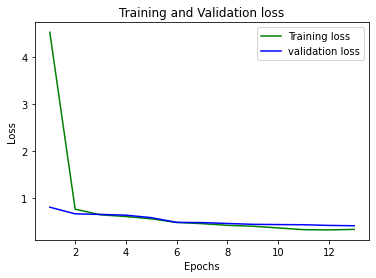

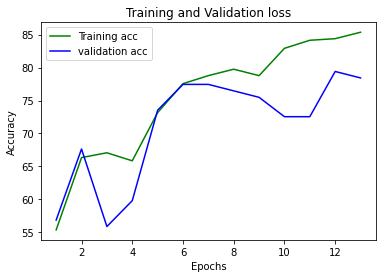

 Training Teacher 2
Epoch: 1 
	Train Loss: 0.453551 	Train Acc: 79.756098 
	Valid Loss: 0.524783 	Valid Acc: 80.392157
Epoch: 2 
	Train Loss: 0.371970 	Train Acc: 83.658537 
	Valid Loss: 0.517986 	Valid Acc: 78.431373
Epoch: 3 
	Train Loss: 0.384925 	Train Acc: 80.975610 
	Valid Loss: 0.533569 	Valid Acc: 81.372549
Epoch: 4 
	Train Loss: 0.330848 	Train Acc: 83.170732 
	Valid Loss: 0.485293 	Valid Acc: 80.392157
Epoch: 5 
	Train Loss: 0.327640 	Train Acc: 84.146341 
	Valid Loss: 0.520107 	Valid Acc: 80.392157
Epoch: 6 
	Train Loss: 0.334327 	Train Acc: 85.609756 
	Valid Loss: 0.512846 	Valid Acc: 79.411765
Epoch: 7 
	Train Loss: 0.336452 	Train Acc: 86.097561 
	Valid Loss: 0.506537 	Valid Acc: 80.392157
Epoch: 8 
	Train Loss: 0.298041 	Train Acc: 86.097561 
	Valid Loss: 0.516552 	Valid Acc: 79.411765
Epoch: 9 
	Train Loss: 0.277917 	Train Acc: 86.829268 
	Valid Loss: 0.508025 	Valid Acc: 76.470588
Epoch: 10 
	Train Loss: 0.250434 	Train Acc: 88.536585 
	Valid Loss: 0.554516 	Valid Acc:

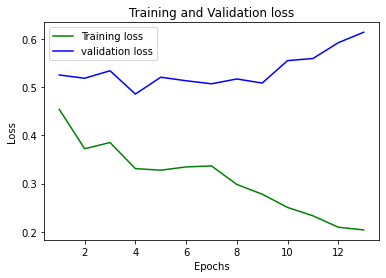

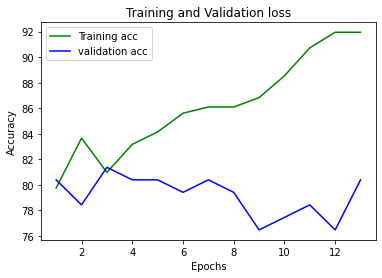

 Training Teacher 3
Epoch: 1 
	Train Loss: 0.465805 	Train Acc: 79.756098 
	Valid Loss: 0.629610 	Valid Acc: 70.588235
Epoch: 2 
	Train Loss: 0.482028 	Train Acc: 81.951220 
	Valid Loss: 0.536040 	Valid Acc: 78.431373
Epoch: 3 
	Train Loss: 0.360916 	Train Acc: 83.658537 
	Valid Loss: 0.539950 	Valid Acc: 76.470588
Epoch: 4 
	Train Loss: 0.397295 	Train Acc: 81.219512 
	Valid Loss: 0.462814 	Valid Acc: 77.450980
Epoch: 5 
	Train Loss: 0.318877 	Train Acc: 84.146341 
	Valid Loss: 0.434019 	Valid Acc: 79.411765
Epoch: 6 
	Train Loss: 0.282868 	Train Acc: 86.585366 
	Valid Loss: 0.445347 	Valid Acc: 78.431373
Epoch: 7 
	Train Loss: 0.289277 	Train Acc: 88.292683 
	Valid Loss: 0.464057 	Valid Acc: 79.411765
Epoch: 8 
	Train Loss: 0.230431 	Train Acc: 89.268293 
	Valid Loss: 0.492041 	Valid Acc: 76.470588
Epoch: 9 
	Train Loss: 0.221939 	Train Acc: 91.219512 
	Valid Loss: 0.484210 	Valid Acc: 76.470588
Epoch: 10 
	Train Loss: 0.191490 	Train Acc: 91.707317 
	Valid Loss: 0.484163 	Valid Acc:

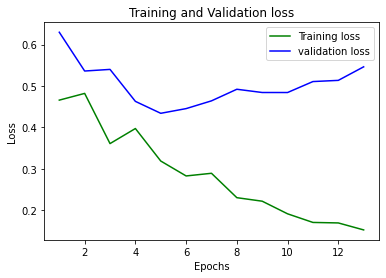

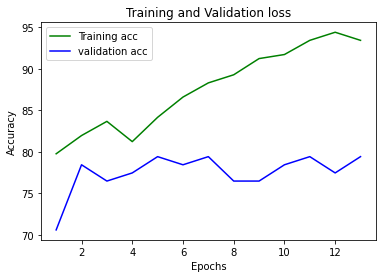

 Training Teacher 4
Epoch: 1 
	Train Loss: 0.691454 	Train Acc: 72.926829 
	Valid Loss: 0.546094 	Valid Acc: 75.490196
Epoch: 2 
	Train Loss: 0.527604 	Train Acc: 77.073171 
	Valid Loss: 0.563705 	Valid Acc: 74.509804
Epoch: 3 
	Train Loss: 0.479827 	Train Acc: 75.365854 
	Valid Loss: 0.503056 	Valid Acc: 77.450980
Epoch: 4 
	Train Loss: 0.436651 	Train Acc: 78.780488 
	Valid Loss: 0.481872 	Valid Acc: 80.392157
Epoch: 5 
	Train Loss: 0.396602 	Train Acc: 80.731707 
	Valid Loss: 0.456500 	Valid Acc: 85.294118
Epoch: 6 
	Train Loss: 0.335981 	Train Acc: 82.439024 
	Valid Loss: 0.434823 	Valid Acc: 83.333333
Epoch: 7 
	Train Loss: 0.316117 	Train Acc: 82.439024 
	Valid Loss: 0.452419 	Valid Acc: 82.352941
Epoch: 8 
	Train Loss: 0.310662 	Train Acc: 85.121951 
	Valid Loss: 0.461751 	Valid Acc: 84.313725
Epoch: 9 
	Train Loss: 0.302088 	Train Acc: 86.585366 
	Valid Loss: 0.444986 	Valid Acc: 85.294118
Epoch: 10 
	Train Loss: 0.285542 	Train Acc: 87.804878 
	Valid Loss: 0.459955 	Valid Acc:

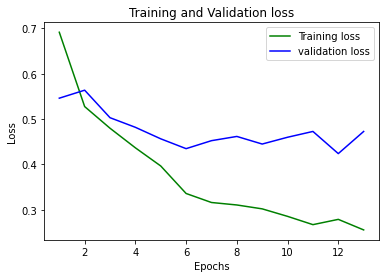

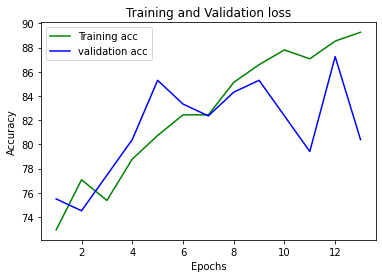

 Training Teacher 5
Epoch: 1 
	Train Loss: 0.360118 	Train Acc: 82.396088 
	Valid Loss: 0.489796 	Valid Acc: 72.549020
Epoch: 2 
	Train Loss: 0.256917 	Train Acc: 87.041565 
	Valid Loss: 0.449296 	Valid Acc: 73.529412
Epoch: 3 
	Train Loss: 0.253840 	Train Acc: 89.731051 
	Valid Loss: 0.427103 	Valid Acc: 74.509804
Epoch: 4 
	Train Loss: 0.219196 	Train Acc: 89.731051 
	Valid Loss: 0.464084 	Valid Acc: 68.627451
Epoch: 5 
	Train Loss: 0.233895 	Train Acc: 90.464548 
	Valid Loss: 0.473240 	Valid Acc: 71.568627
Epoch: 6 
	Train Loss: 0.201808 	Train Acc: 87.775061 
	Valid Loss: 0.537533 	Valid Acc: 73.529412
Epoch: 7 
	Train Loss: 0.268013 	Train Acc: 90.709046 
	Valid Loss: 0.475941 	Valid Acc: 72.549020
Epoch: 8 
	Train Loss: 0.172268 	Train Acc: 92.665037 
	Valid Loss: 0.566514 	Valid Acc: 68.627451
Epoch: 9 
	Train Loss: 0.182991 	Train Acc: 92.665037 
	Valid Loss: 0.523468 	Valid Acc: 70.588235
Epoch: 10 
	Train Loss: 0.143727 	Train Acc: 94.376528 
	Valid Loss: 0.487106 	Valid Acc:

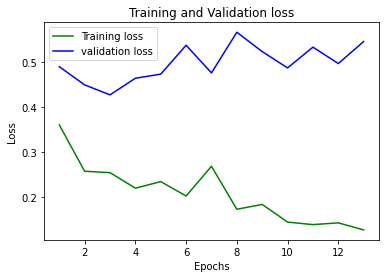

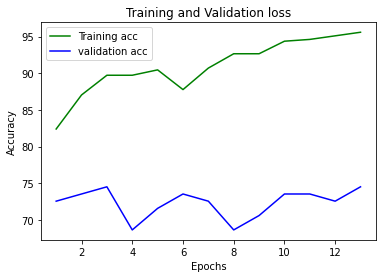

In [ ]:
#Training teachers
teacher_models = []
i = 1
for trainloader, validloader in zip(trainloaders, validloaders):
  print(" Training Teacher {}".format(i))
  teacher_model = train(epochs, trainloader, validloader, model, optimizer, criterion, True)
  teacher_models.append(teacher_model)
  i+=1
  print("="*40)

In [ ]:
#Get private labels for training student
# get private labels
def student_train_labels(teacher_models, dataloader):
  student_labels = []

  # get label from each teacher
  for model in teacher_models:
    student_label = []
    for images,_ in dataloader:
      with torch.no_grad():
        images = images.cuda()
        outputs = model(images)
        preds = torch.argmax(torch.exp(outputs), dim=1)
      student_label.append(preds.tolist())

    # add all teacher predictions to student_labels  
    student_label = sum(student_label, [])
    student_labels.append(student_label)
  return student_labels

predicted_labels = student_train_labels(teacher_models, student_train_loader)     
predicted_labels = np.array([np.array(p) for p in predicted_labels]).transpose(1, 0)

# We see here that we have 5 labels for each image in our dataset
print(predicted_labels.shape)
# See labels of 3rd Image Scan
print(predicted_labels[3])

(468, 5)
[0 0 0 0 0]




---


Each image of the test set will have number of teacher number of labels.

---




In [ ]:
#Get private labels with the most votes count and add noise them
def add_noise(predicted_labels, epsilon=0.001):
  noisy_labels = []
  for preds in predicted_labels:

    # get labels with max votes
    label_counts = np.bincount(preds, minlength=2)

    # add laplacian noise to label
    epsilon = epsilon
    beta = 1/epsilon
    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)

    # after adding noise we get labels with max counts
    new_label = np.argmax(label_counts)
    noisy_labels.append(new_label)

  #return noisy_labels
  return np.array(noisy_labels)

labels_with_noise = add_noise(predicted_labels, epsilon=0.01)  
print(labels_with_noise)
print(labels_with_noise.shape)

[1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1
 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1
 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0
 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0
 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0
 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0
 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0
 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1
 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0
 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0]
(468,)




---


The generated private labels are agreggated and the most votes labels by all the teachers are selected and statistical noise is added to them.


---



In [ ]:
import csv
def write_csv(data):
    with open('labels.csv', 'w') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(data)

write_csv(labels_with_noise)

In [ ]:
# Performing PATE analysis
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=predicted_labels.T, indices=labels_with_noise, noise_eps=0.01, delta=1e-5)
print('Data dependent epsilon:', data_dep_eps)
print('Data independent epsilon:', data_ind_eps)

Data dependent epsilon: 2.281515683121286
Data independent epsilon: 2.2815156831212784




---
**Data independent epsilon**:- privacy loss in the worst case.

**Data dependent epsilon**:- tight bound of privacy loss based on the teacher outputs, it tells us how well the teachers agree.

**Lesser the epsilon value more is the model privacy**.


---




In [ ]:
# We have to create a new training dataloader for the student with the newly created
# labels with noise. We have to replace the old labels with the new labels
def new_student_data_loader(dataloader, noisy_labels, batch_size=20):
  image_list = []
  for image,_ in dataloader:
    image_list.append(image)

  data = np.vstack(image_list)
  new_dataset = list(zip(data, noisy_labels))
  new_dataloader = DataLoader(new_dataset, batch_size, shuffle=False)

  return new_dataloader

labeled_student_trainloader = new_student_data_loader(student_train_loader, labels_with_noise)
len(labeled_student_trainloader),len(student_valid_loader)

(24, 6)

Epoch: 1 
	Train Loss: 1.002147 	Train Acc: 52.564103 
	Valid Loss: 0.672523 	Valid Acc: 50.000000
	Validation loss decreased (inf --> 0.672523).  Saving model ...
Epoch: 2 
	Train Loss: 0.686763 	Train Acc: 50.427350 
	Valid Loss: 0.679147 	Valid Acc: 48.275862
Epoch: 3 
	Train Loss: 0.686681 	Train Acc: 51.923077 
	Valid Loss: 0.678235 	Valid Acc: 48.275862
Epoch: 4 
	Train Loss: 0.676502 	Train Acc: 56.623932 
	Valid Loss: 0.671370 	Valid Acc: 75.862069
	Validation loss decreased (0.672523 --> 0.671370).  Saving model ...
Epoch: 5 
	Train Loss: 0.670712 	Train Acc: 56.837607 
	Valid Loss: 0.668207 	Valid Acc: 68.103448
	Validation loss decreased (0.671370 --> 0.668207).  Saving model ...
Epoch: 6 
	Train Loss: 0.643480 	Train Acc: 60.256410 
	Valid Loss: 0.677343 	Valid Acc: 69.827586
Epoch: 7 
	Train Loss: 0.612578 	Train Acc: 63.675214 
	Valid Loss: 0.698486 	Valid Acc: 64.655172
Epoch: 8 
	Train Loss: 0.567141 	Train Acc: 68.162393 
	Valid Loss: 0.759337 	Valid Acc: 60.344828
Epo

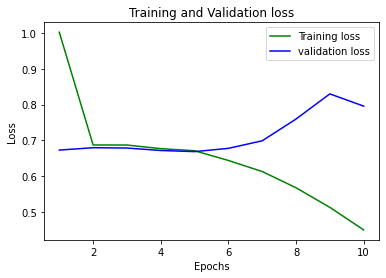

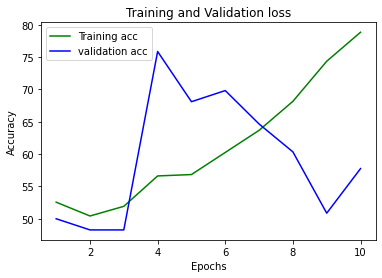

In [ ]:
epochs = 10
student_model = train(epochs, labeled_student_trainloader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/student.pth.tar', is_not_teacher=True)

In [ ]:
# Create a dataloader for the test Dataset
batch_size=16
print(len(validset))
dataloader = DataLoader(validset, batch_size=batchsize, shuffle=False)

146


In [ ]:
# We set a seed for the dataset to prevent it from producing different values every time it is run
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def test(dataloader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    Y_true = []
    Y_pred = []
    
    model.eval()
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the loss
        loss = criterion(output, target)

        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        temp_pred = pred 
        
        Y_pred+=(temp_pred.cpu().numpy().transpose().tolist())
        # print(temp_pred.cpu().numpy().transpose())
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('\tTest Loss: {:.6f}'.format(test_loss))
    print('\tTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    Y_pred = sum(Y_pred,[])
    
    Y_true = [int(dataloader.dataset.img_list[i][1]) for i in range(len(dataloader.dataset.img_list)) ]
    print("CONFUSION MATRIX:\n")
    print(confusion_matrix(Y_true,Y_pred))

# call test function
print("Student Model")     
test(dataloader, student_model, criterion, True)


